# 1. Setup

In [ ]:
# TODO: clean this up
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm
import re
import string
import nltk
import torch
import transformers as ppb
from nltk import pos_tag, download
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from math import ceil
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

In [51]:
# Load the dataset from the Hugging Face Hub
notebook_tqdm.tqdm.pandas()
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech')

# Convert the dataset to a pandas DataFrame
df_raw = dataset['train'].to_pandas()

In [52]:
TRAIN_RATIO = 0.8 # TODO: factor this out everywhere
TEST_RATIO = 1 - TRAIN_RATIO
HATE_SPEECH_THRESHOLD_UNNORMALIZED = 0.5
SUPPORTIVE_THRESHOLD_UNNORMALIZED = -1
EVALUATION_METRICS = ['precision', 'recall', 'f1-score']

In [53]:
results = []

# 2. Filtering & EDA

### 2.0. Function definitions & variables

In [54]:
def plot_hate_speech_score_histogram(df: pd.DataFrame, hate_threshold: float, supportive_threshold: float):
    """
    Plots a histogram of the hate_speech_score with annotated lines at the thresholds

    Args:
        df (pd.DataFrame): The dataframe to plot the histogram from
        hate_threshold (float): The threshold for hate speech
        supportive_threshold (float): The threshold for supportive speech

    Returns:
        None (plots the histogram)
    """

    total_count = df.shape[0]
    
    # Calculate the amount of values below the supportive threshold
    supportive_count = df[df['hate_speech_score'] < supportive_threshold].shape[0]

    # Calculate the amount of values above the hate threshold
    hate_count = df[df['hate_speech_score'] > hate_threshold].shape[0]

    # Calculate the amount of values between the thresholds
    neutral_count = df[(df['hate_speech_score'] >= supportive_threshold) & (df['hate_speech_score'] <= hate_threshold)].shape[0]

    print(f"Total count: {total_count}")
    print(f"Supportive count: {supportive_count} ({supportive_count / total_count * 100:.2f}%)")
    print(f"Hate count: {hate_count} ({hate_count / total_count * 100:.2f}%)")
    print(f"Neutral count: {neutral_count} ({neutral_count / total_count * 100:.2f}%)")

    # Plot in histogram as well
    plt.hist(df['hate_speech_score'], bins=100)
    plt.axvline(hate_threshold, color='red', linestyle='--', label='Hate Speech Threshold')
    plt.axvline(supportive_threshold, color='blue', linestyle='--', label='Supportive Threshold')
    plt.legend()
    plt.show()

def plot_target_columns_distribution(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a barchart of the average value of the target columns for the hate speech observations

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distribution)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # Calculate the mean value of the target columns for the hate speech observations and sort them descending
    mean_values = hate_speech_df[target_cols].mean()
    mean_values = mean_values.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    mean_values.plot(kind='bar')
    plt.title('Percentage of hate speech columns targeting a specific group')
    plt.xlabel('Target Column')
    plt.ylabel('Percentage of hate speech')
    plt.show()

def plot_target_columns_detailed(df: pd.DataFrame, target_cols: list[str], fig_size: tuple[int, int] = (15, 30), y_max: float = 0.35):
    """
    Plots a bar chart for each of the target columns with detailed breakdowns of sub-groups

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distributions)

    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # initalize axes to plot the 7 sub-groups in two rows of 3 and a last row of 1
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=fig_size)
    # For each of the target columns, make a list of means of of hate speach targeting its sub-groups
    for ax, col in zip(axes.flatten(), target_cols):

        # Calculate the number of observations with a non-zero value for the target column
        non_zero_count = hate_speech_df[col].value_counts()[1]

        # identify all columns in the dataframe that starts with the target column name
        sub_groups_column_names = [column for column in df.columns if column.startswith(col)]

        # remove the original target column from the list
        sub_groups_column_names.remove(col)
        col_name = col.replace("target_", "").title()

        # calculate the mean values for each sub-group
        sub_group_means = hate_speech_df[sub_groups_column_names].mean()
        sub_group_means = sub_group_means.sort_values(ascending=False)

        # remove the col string from the labels
        labels = sub_group_means.index.str.replace((col + "_"), '')

        # plot on the specific axis
        sub_group_means.plot(kind='bar', ax=ax)
        ax.set_xticklabels(labels)
        ax.set_title(f'Percentage of hate speech targeting {col_name} by sub-group \n(n={non_zero_count})')
        ax.set_xlabel('Sub-group')
        ax.set_ylabel('Percentage of hate speech')
        ax.set_ylim(0, y_max)
    
    plt.subplots_adjust(hspace=0.7)

def inspect_for_cor(df, columns: list[str], plot_label: str, hate_speech_only: bool = True):

    # filter for hate speech only if specified
    if hate_speech_only:
        df = df[df['is_hate_speech'] == 1]
    
    # Make a correlation matrix
    corr_matrix = df[columns].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {plot_label}')
    plt.show()

    # Make a pairplot of the columns
    sns.pairplot(df[columns])
    plt.title(f'Pairplot for {plot_label}')
    plt.show()


In [55]:
aspect_cols = [
    'insult',
    'humiliate',
    'status',
    'dehumanize',
    'violence',
    'genocide'
]

target_cols_lvl1_and_2 = [col for col in df_raw.columns if col.startswith('target_')]

target_cols_lvl1 = [
    'target_race',
    'target_religion',
    'target_origin',
    'target_gender',
    'target_sexuality',
    'target_age',
    'target_disability',    
]

cols_to_keep = [
    'comment_id', 
    'text', 
    'hate_speech_score',
    *aspect_cols,
    *target_cols_lvl1_and_2
]


### 2.1. Pre-filtering EDA

Total count: 135556
Supportive count: 53651 (39.58%)
Hate count: 49048 (36.18%)
Neutral count: 32857 (24.24%)


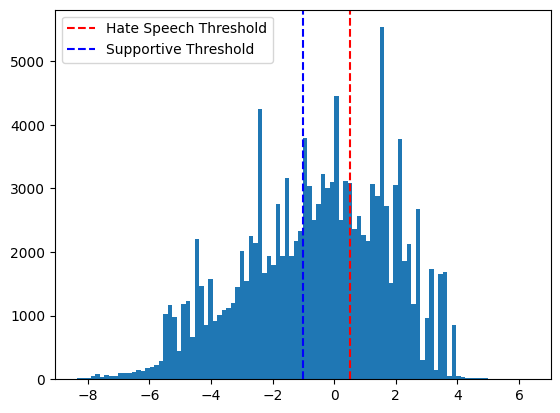

In [56]:
plot_hate_speech_score_histogram(df_raw, HATE_SPEECH_THRESHOLD_UNNORMALIZED, SUPPORTIVE_THRESHOLD_UNNORMALIZED)

### 2.2. Filtering & reformating

TODO: Make list of filtering actions for report 


In [57]:
# Check for duplicate rows based on the 'comment_id' column
duplicate_texts = df_raw[df_raw.duplicated(subset='comment_id', keep=False)]
print(f"Number of duplicate texts: {duplicate_texts.shape[0]}")
duplicate_texts[['comment_id', 'text']].head()

Number of duplicate texts: 125479


,comment_id,text
0,47777,Yes indeed. She sort of reminds me of the elde...
1,39773,The trans women reading this tweet right now i...
2,47101,Question: These 4 broads who criticize America...
3,43625,It is about time for all illegals to go back t...
4,12538,For starters bend over the one in pink and kic...


In [58]:
# Group by 'comment_id' and count unique 'hate_speech_score' values per group
score_check = df_raw.groupby("comment_id")["hate_speech_score"].nunique()

# Find texts with more than one unique score
inconsistent = score_check[score_check > 1]

# Show how many inconsistencies there are
print(f"Number of 'comment_id' entries with inconsistent scores: {len(inconsistent)}")

# Optionally, view a few examples
if not inconsistent.empty:
    print(df_raw[df_raw["comment_id"].isin(inconsistent.index)].sort_values("comment_id").head(10))

Number of 'comment_id' entries with inconsistent scores: 0


In [59]:
# Step 1: Select relevant columns
df_relevant = df_raw[cols_to_keep].copy()

# Step 2: Convert booleans to integers for mean calculation
bool_cols = [col for col in df_relevant.columns if col.startswith('target_')]
df_relevant[bool_cols] = df_relevant[bool_cols].astype(int)

# Step 3: Group by 'comment_id' and 'text' to keep them in final output
filtered_df = df_relevant.groupby(['comment_id', 'text']).mean().reset_index()

In [60]:
min_score = filtered_df['hate_speech_score'].min()  # e.g., -8.34
max_score = filtered_df['hate_speech_score'].max()  # e.g., +6.3

# replace hate speech core column with normalized column - [0, 1]
filtered_df['hate_speech_score'] = (filtered_df['hate_speech_score'] - min_score) / (max_score - min_score)


In [61]:
# Normalize the thresholds given by the dataset authors
HATE_SPEECH_THRESHOLD_NORMALIZED = (0.5 - min_score) / (max_score - min_score)  
SUPPORTIVE_THRESHOLD_NORMALIZED = (-1 - min_score) / (max_score - min_score)

# Add binary columns for hate speech
filtered_df.insert(filtered_df.columns.get_loc('hate_speech_score') + 1, 'is_hate_speech', (filtered_df['hate_speech_score'] > HATE_SPEECH_THRESHOLD_NORMALIZED).astype(int))

# Print new normalized thresholds 
print(f"Threshold for hate speech: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} on the original scale")
print(f"Threshold for counter speech: {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {-1} on the original scale")
print(f"Between the two thresholds: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} and {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} and {-1} on the original scale which is the unambiguous region")


Threshold for hate speech: 0.604 -> Equivalent to 0.5 on the original scale
Threshold for counter speech: 0.501 -> Equivalent to -1 on the original scale
Between the two thresholds: 0.604 and 0.501 -> Equivalent to 0.5 and -1 on the original scale which is the unambiguous region


In [62]:
filtered_df.describe()

,comment_id,hate_speech_score,is_hate_speech,insult,humiliate,status,dehumanize,violence,genocide,target_race_asian,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,...,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,25064.175028,0.505197,0.261696,2.451707,2.170926,2.560852,1.700071,0.825427,0.448814,0.036070,...,0.001216,0.024744,0.002986,0.013872,0.006091,0.001186,0.001254,0.006339,0.002392,0.025676
std,14573.790336,0.141604,0.439563,1.185507,1.147433,0.699245,1.098025,1.000165,0.765847,0.161093,...,0.028330,0.137500,0.046627,0.105851,0.068472,0.029225,0.030446,0.068151,0.041602,0.146039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12336.000000,0.410519,0.000000,1.666667,1.333333,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24986.000000,0.521858,0.000000,3.000000,2.333333,2.500000,1.666667,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37837.000000,0.608607,1.000000,3.333333,3.000000,3.000000,2.500000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50070.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comment_id                             39565 non-null  int32  
 1   text                                   39565 non-null  object 
 2   hate_speech_score                      39565 non-null  float64
 3   is_hate_speech                         39565 non-null  int64  
 4   insult                                 39565 non-null  float64
 5   humiliate                              39565 non-null  float64
 6   status                                 39565 non-null  float64
 7   dehumanize                             39565 non-null  float64
 8   violence                               39565 non-null  float64
 9   genocide                               39565 non-null  float64
 10  target_race_asian                      39565 non-null  float64
 11  ta

### 2.3. Post-filtering EDA

Total count: 39565
Supportive count: 17475 (44.17%)
Hate count: 10354 (26.17%)
Neutral count: 11736 (29.66%)


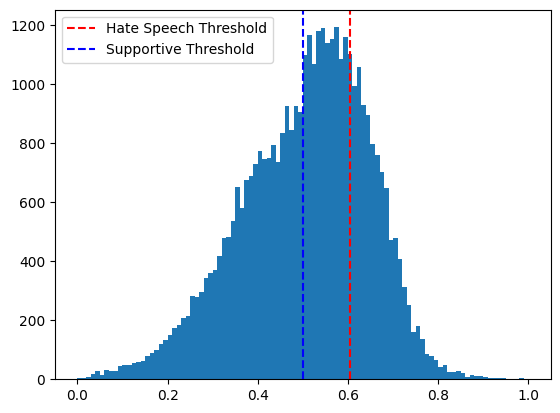

In [64]:
plot_hate_speech_score_histogram(filtered_df, HATE_SPEECH_THRESHOLD_NORMALIZED, SUPPORTIVE_THRESHOLD_NORMALIZED)

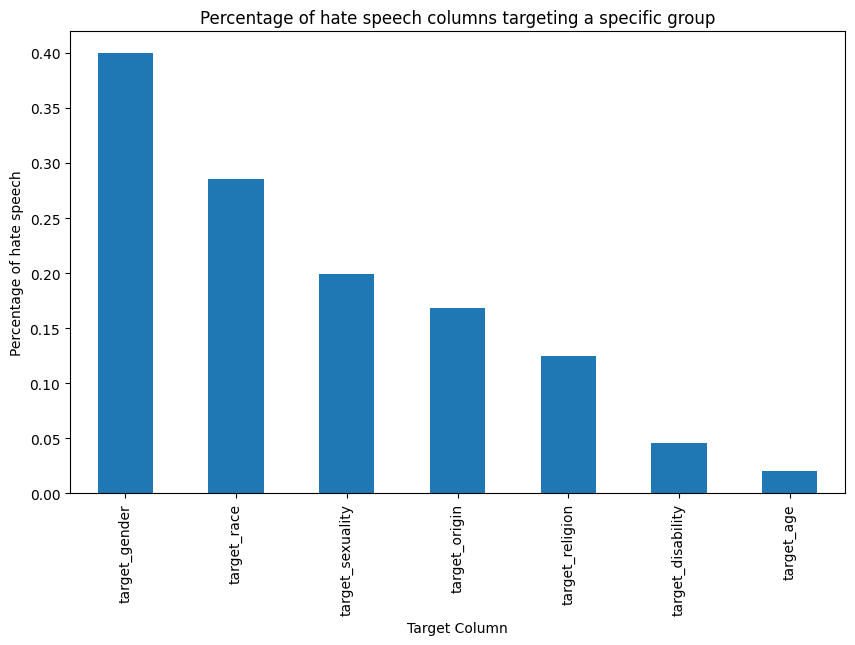

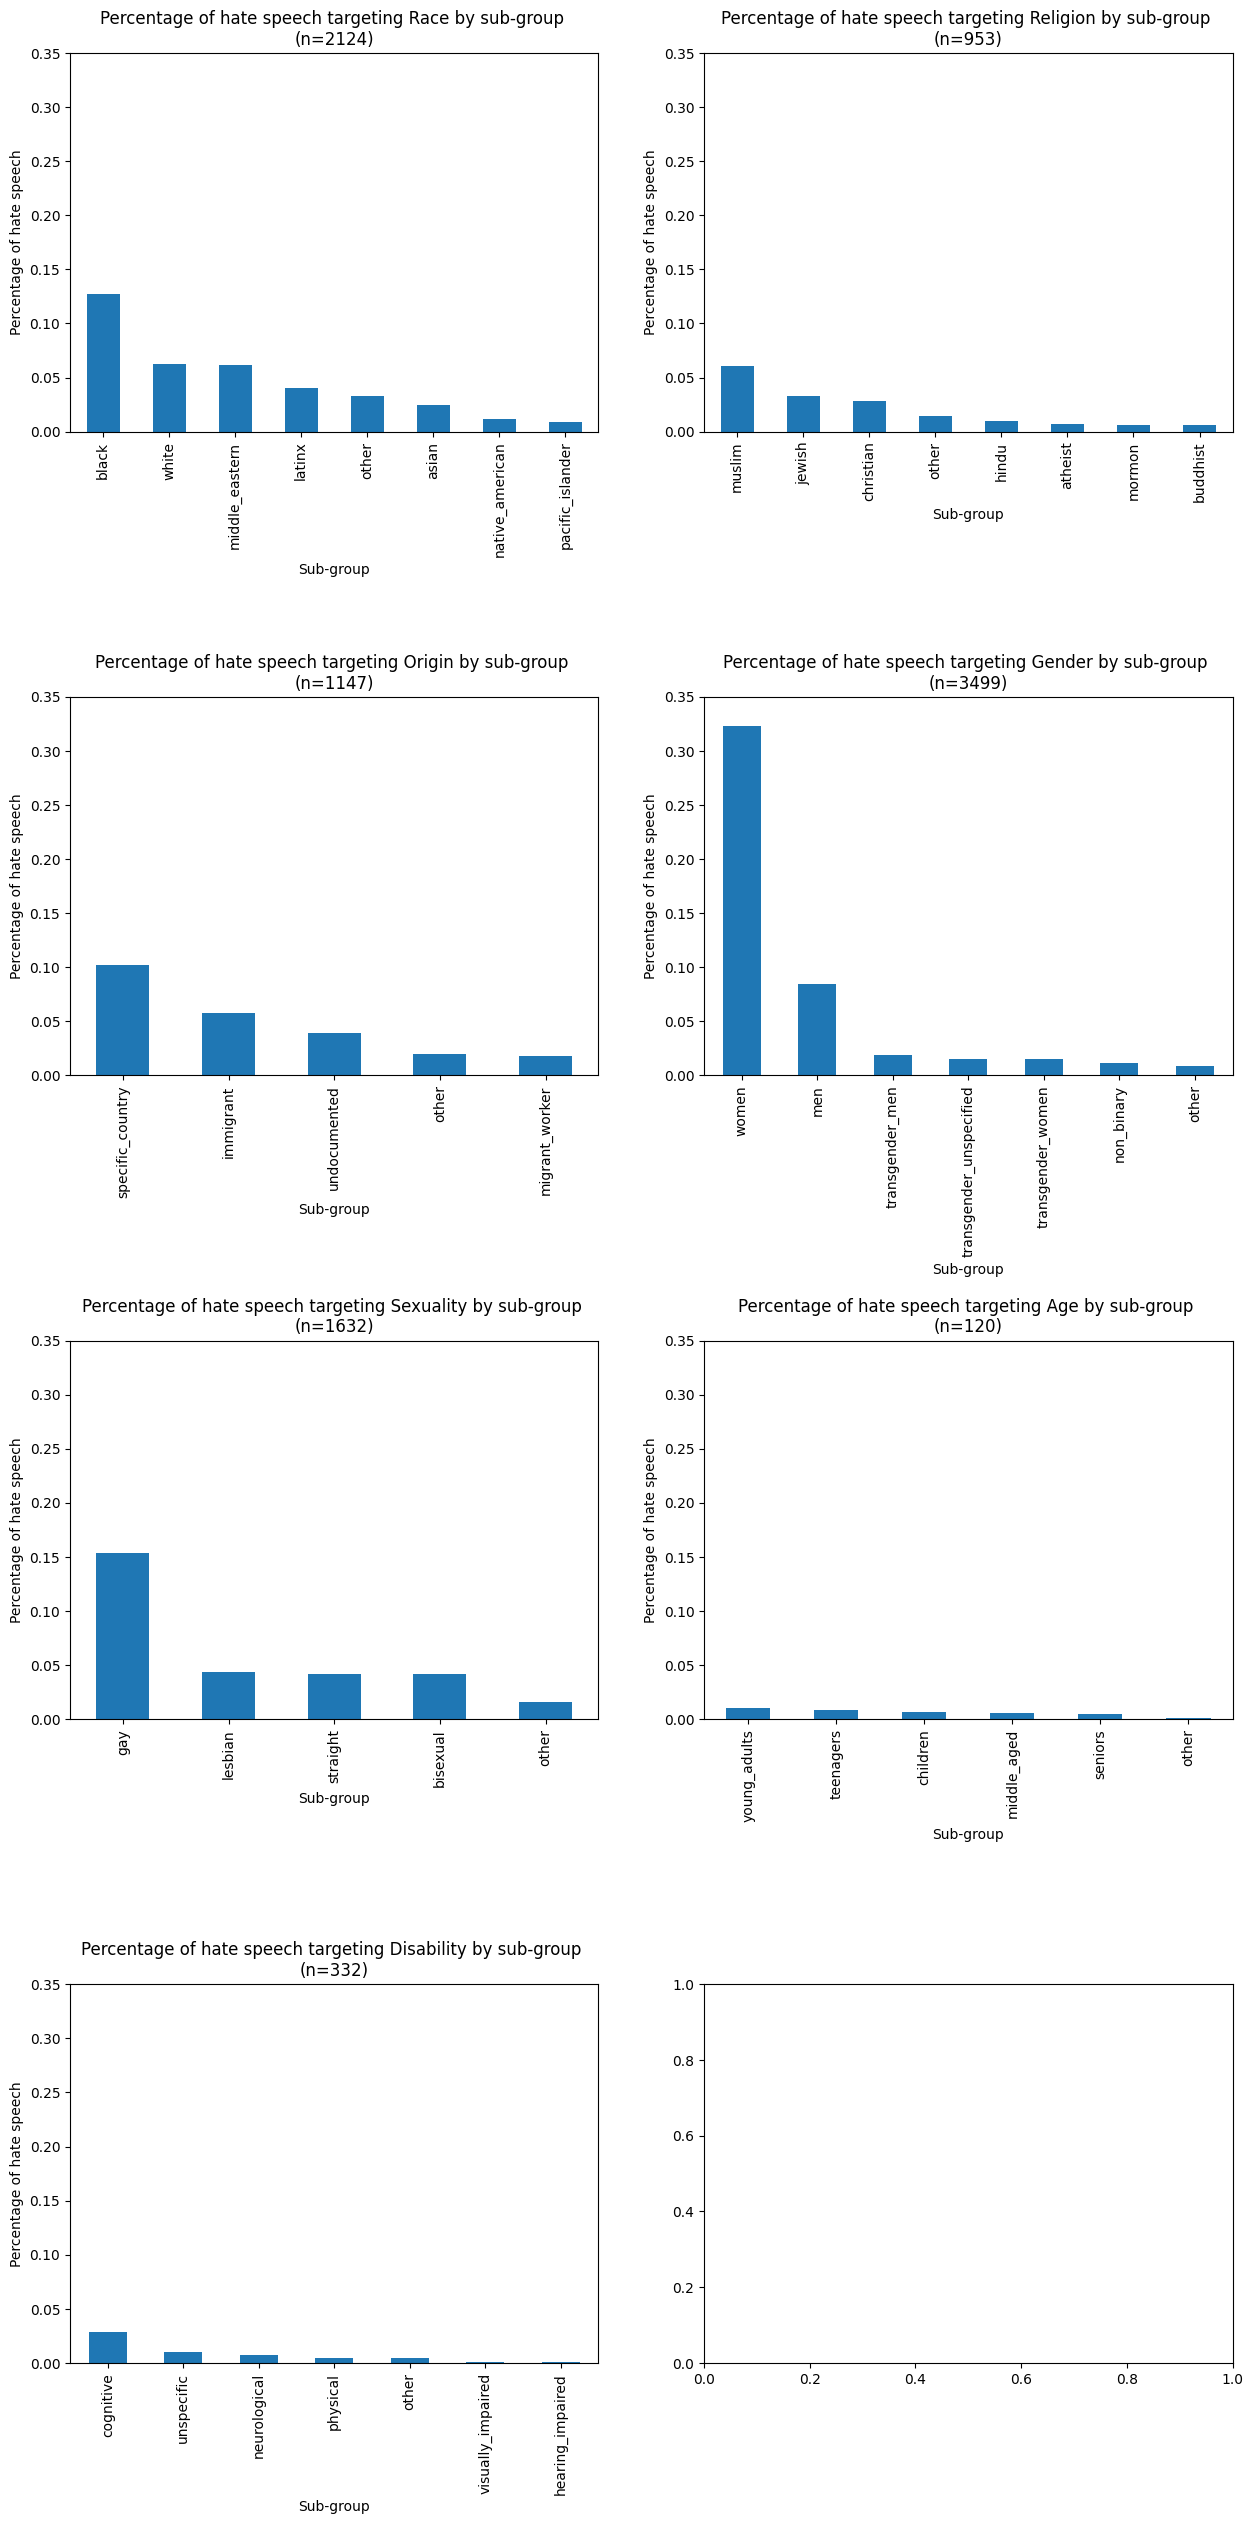

In [65]:
plot_target_columns_distribution(filtered_df, target_cols_lvl1)
plot_target_columns_detailed(filtered_df, target_cols_lvl1)

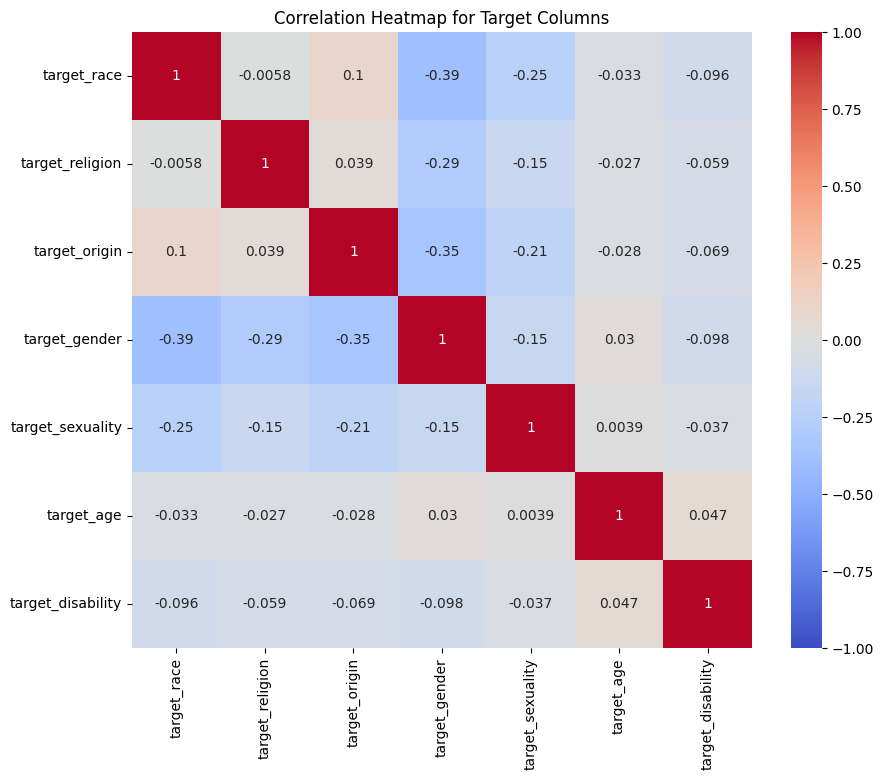

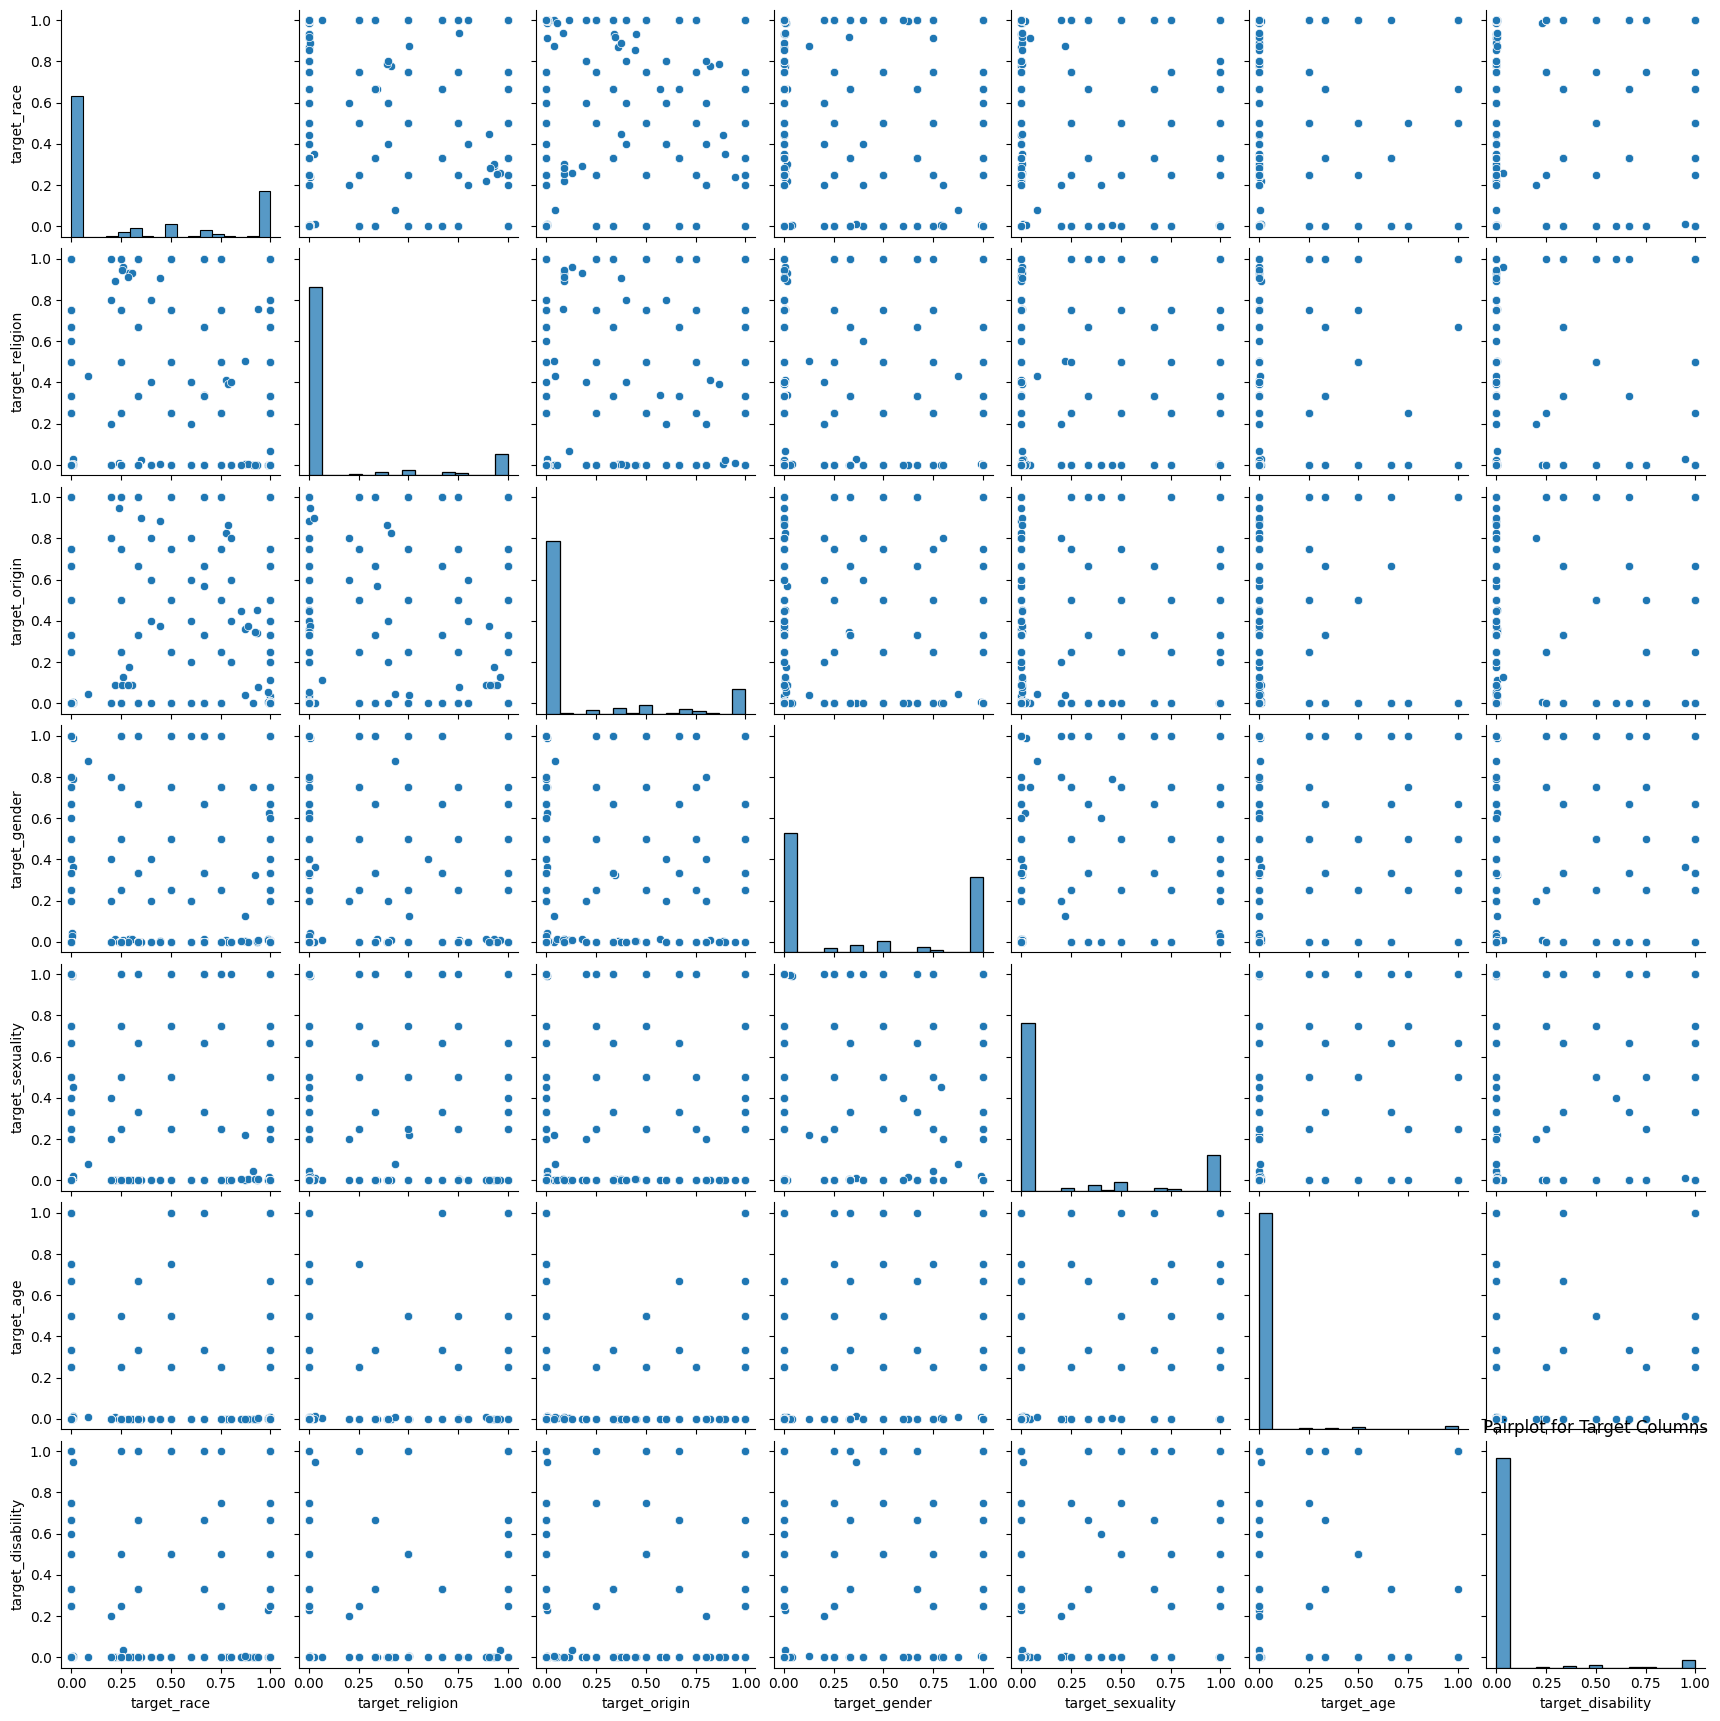

In [66]:
inspect_for_cor(filtered_df, target_cols_lvl1, 'Target Columns')

In [ ]:
# Binary labels
filtered_df["is_supportive"] = (
    filtered_df["hate_speech_score"] < SUPPORTIVE_THRESHOLD_NORMALIZED
).astype(int)

# Keep only hate (1) or supportive (0); drop neutral rows
df_binary = filtered_df.loc[
    (filtered_df["is_hate_speech"] == 1) | (filtered_df["is_supportive"] == 1),
    ["comment_id", "text", "is_hate_speech", "is_supportive"]
].copy()

# Single label column: 1 = hate, 0 = supportive
df_binary["label"] = df_binary["is_hate_speech"]

print("Before sampling:")
print(df_binary["label"].value_counts())

# Random under-sampling
# Splitting by class
df_hate = df_binary[df_binary["label"] == 1]
df_sup  = df_binary[df_binary["label"] == 0]

# Size of minority class
n_samples = min(len(df_hate), len(df_sup))

# Under-sample the majority
df_hate_down = resample(
    df_hate, replace=False, n_samples=n_samples, random_state=42
)
df_sup_down = resample(
    df_sup,  replace=False, n_samples=n_samples, random_state=42
)

# Combine & shuffle
df_balanced = pd.concat([df_hate_down, df_sup_down]).sample(
    frac=1, random_state=42
).reset_index(drop=True)

print("\nAfter sampling:")
print(df_balanced["label"].value_counts())


Before sampling:
label
0    17475
1    10354
Name: count, dtype: int64

After sampling:
label
0    10354
1    10354
Name: count, dtype: int64


In [68]:
X = df_balanced["text"]
y = df_balanced["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=TRAIN_RATIO,
    stratify=y,          # keeps 50/50 in each split
    random_state=42
)

In [ ]:
df_balanced = df_balanced.drop(columns="label")

# Overwriting the old dataframe 
filtered_df = df_balanced.reset_index(drop=True)

# Verification of the sampling
print("\nBalanced label distribution:")
print(filtered_df["is_hate_speech"].value_counts())



Balanced label distribution:
is_hate_speech
0    10354
1    10354
Name: count, dtype: int64


# 3. Models

### 3.0 Function & Class definitions

In [70]:
def append_results(results: list, report: dict, model_name: str, metrics: list[str]):
    
    append_dict = {}

    for metric in metrics:
        append_dict[f'{metric}_hate'] = report['1'][metric]
        append_dict[f'{metric}_non_hate'] = report['0'][metric]
        append_dict[f'{metric}_macro_avg'] = report['macro avg'][metric]
        append_dict[f'{metric}_weighted_avg'] = report['weighted avg'][metric]

    append_dict['accuracy'] = report['accuracy']

    results.append({
        'model': model_name,
        **append_dict
    })

def get_wordnet_pos(tag):
    """
    Convert the part of speech tag to a format that WordNet lemmatizer can understand.
    starts with 'J' for adjectives, 'V' for verbs, 'N' for nouns, and 'R' for adverbs.
    Args:
        tag (str): The part of speech tag.
    Returns:
        str: The WordNet part of speech tag.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def is_ascii(token):
    return all(ord(c) < 128 for c in token)

def remove_repeated_chars(token, threshold=3):
    return re.sub(r'(.)\1{' + str(threshold) + r',}', r'\1', token)

def bow_preprocess(text):
    """
    Preprocess the text by tokenizing, removing punctuation, stop words,
    and lemmatizing the words.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    Example:
        >>> preprocess("This is an EXAMPLE sentence!!!.")
        'example sentence'
        
    """
    tokens = tknzr.tokenize(text) # Tokenize the text
    tokens = [word.lower() for word in tokens if word not in string.punctuation] # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [remove_repeated_chars(word) for word in tokens] # Remove repeated characters, ex: "loooove" -> "love"
    tokens = [word for word in tokens if len(word) >= 2 and is_ascii(word)]  # Filter by length and ASCII
    pos_tags = pos_tag(tokens) # Get part of speech tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags] # Lemmatize the words using the part of speech tags
    return " ".join(lemmatized)

def stream_batches(texts, labels, batch_size=32, max_length=256):
    """
    Streams batches into SGD classifier

    Args:
        texts (pd.Series): The texts to stream
        labels (pd.Series): The labels to stream
        batch_size (int): The batch size
        max_length (int): The maximum length of the texts
    
    Returns:
        generator: A generator of batches
    """
    n = len(texts)
    n_batches = ceil(n / batch_size)

    # Iterate over the batches to yield them one by one
    for i in range(n_batches):
        batch_texts = texts.iloc[i*batch_size:(i+1)*batch_size].tolist()
        batch_labels = labels.iloc[i*batch_size:(i+1)*batch_size].values
        
        # dynamic padding + truncation
        enc = bert_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        yield enc["input_ids"], enc["attention_mask"], batch_labels


In [71]:
class BOWTextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.progress_apply(bow_preprocess)

### 3.1. BoW + Logistic Regression

In [72]:
# Dataframe for Bag of Words (BoW) representation
bow_df = filtered_df.copy()

# Releveant columns
bow_cols = ['text', 'is_hate_speech']

# Select relevant columns
bow_df = bow_df[bow_cols]


In [73]:
label_counts = bow_df['is_hate_speech'].value_counts()
label_percentage = bow_df['is_hate_speech'].value_counts(normalize=True) * 100

print("Label Counts:")
print(label_counts)
print("\nLabel Percentage Distribution:")
print(label_percentage)

Label Counts:
is_hate_speech
0    10354
1    10354
Name: count, dtype: int64

Label Percentage Distribution:
is_hate_speech
0    50.0
1    50.0
Name: proportion, dtype: float64


##### 3.1.1 Data preprocessing

TODO: Maybe remove preprocessing from pipepine to just have it done once for "Part 2" of Assignment 3 approach

In [74]:
# Download necessary NLTK resources
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

# Tokenizer
tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



In [75]:
bow_pipeline = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [76]:
X = bow_df['text']
y = bow_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)


##### 3.1.2. Fit model to training set - BoW + LogReg

In [77]:
# Fit the pipeline to the training data
bow_pipeline.fit(X_train, y_train)


100%|██████████| 16566/16566 [00:06<00:00, 2747.62it/s]


Pipeline(steps=[('preprocessor', BOWTextPreprocessor()),
                ('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [78]:
# Make predictions on the test set
y_pred_bow = bow_pipeline.predict(X_test)

# Generate the classification report
report_bow = classification_report(y_test, y_pred_bow, output_dict=True)

100%|██████████| 4142/4142 [00:01<00:00, 2818.62it/s]


In [79]:
append_results(results, report_bow, 'BoW + LogisticRegression', EVALUATION_METRICS)

### 3.2 TF-IDF + Logistic Regression

In [80]:
pipeline_tfidf = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

100%|██████████| 4142/4142 [00:01<00:00, 2910.70it/s]


In [81]:
append_results(results, report_tfidf, 'TF-IDF + LogisticRegression', EVALUATION_METRICS)

##### 3.2.2 Hyperparameter tuning with GridSearchCV

In [82]:
pipeline_tuned = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),  # or CountVectorizer()
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__max_df': [0.75, 0.9],
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # Needed to compare L1 and L2
}

grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=3, 
    scoring='f1', 
    verbose=2, 
    n_jobs=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


100%|██████████| 5522/5522 [00:01<00:00, 2813.33it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   6.0s


100%|██████████| 5522/5522 [00:01<00:00, 2855.48it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   6.0s


100%|██████████| 5522/5522 [00:01<00:00, 2950.86it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2928.27it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2950.78it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2827.66it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   6.2s


100%|██████████| 5522/5522 [00:01<00:00, 2896.75it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2999.28it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3006.91it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2941.69it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3041.78it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:02<00:00, 2696.20it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   6.0s


100%|██████████| 5522/5522 [00:01<00:00, 2966.49it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3030.78it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3012.46it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2981.83it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2994.10it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 3005.21it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2888.54it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3028.94it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3009.49it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2982.22it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3043.68it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2975.54it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2981.07it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3032.27it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3007.36it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2811.92it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3037.25it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 3019.29it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2936.10it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3034.43it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3015.72it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2989.17it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3041.23it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2972.28it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2976.86it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3031.02it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3011.08it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2940.16it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 3045.49it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 3019.45it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2984.38it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2991.92it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3012.88it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2988.42it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3040.10it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3005.77it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2942.24it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3033.40it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 3010.82it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2950.77it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3040.89it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 3026.12it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2985.75it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2990.15it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 3014.58it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.6s


100%|██████████| 5522/5522 [00:01<00:00, 2993.19it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3042.93it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 3016.31it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2762.73it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2932.22it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2970.40it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2939.50it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2988.80it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2971.27it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2879.22it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2949.67it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.9s


100%|██████████| 5522/5522 [00:02<00:00, 2735.04it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2867.37it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   6.2s


100%|██████████| 5522/5522 [00:01<00:00, 2849.89it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   6.1s


100%|██████████| 5522/5522 [00:01<00:00, 2853.44it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   6.0s


100%|██████████| 5522/5522 [00:01<00:00, 2842.73it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   6.0s


100%|██████████| 5522/5522 [00:01<00:00, 2958.83it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2810.44it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   6.0s


100%|██████████| 5522/5522 [00:01<00:00, 2939.52it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2985.29it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2952.28it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2924.13it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2985.66it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2947.54it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2933.03it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2978.89it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2946.78it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2934.91it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2984.47it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2947.06it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2946.24it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2989.85it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2956.85it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2933.26it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2885.64it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.8s


100%|██████████| 5522/5522 [00:01<00:00, 2895.13it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=   5.7s


100%|██████████| 5522/5522 [00:01<00:00, 2892.59it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2935.49it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   5.9s


100%|██████████| 5522/5522 [00:01<00:00, 2840.86it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=   6.0s


100%|██████████| 16566/16566 [00:05<00:00, 2959.75it/s]


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor', BOWTextPreprocessor()),
                                       ('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=1,
             param_grid={'classifier__C': [0.1, 1],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear'],
                         'vectorizer__max_df': [0.75, 0.9],
                         'vectorizer__max_features': [5000, 10000],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=2)

In [83]:

print("Best params:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# Use best model to predict test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

append_results(results, report_tuned, 'Tuned BoW + LogisticRegression', EVALUATION_METRICS)



Best params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validated F1 score: 0.8269013545281737


100%|██████████| 4142/4142 [00:01<00:00, 3040.96it/s]


### 3.3. BERT + Logistic Regression

##### 3.3.1. Load model

In [84]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)



In [85]:
bert_df = filtered_df.copy()

# Optional: Take a subset to ease computational load
bert_df = bert_df.sample(frac=1)

X = bert_df['text']
y = bert_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)

batch_size = 16
num_batches = ceil(len(X_train) / batch_size)



Computing class weights for the balance_weight argument in partial fit (TODO: remove this and "class weight" argument from model instantiation if we decide to do under/oversampling instead)

In [86]:
# classes must match what you’ll pass to partial_fit
classes = np.array([0, 1])

# Compute: this returns an array [w_for_0, w_for_1]
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train,             # your full training-label vector
)

# Turn it into a dict: { class_label: weight, … }
class_weight_dict = {c: w for c, w in zip(classes, weights)}

In [87]:
# Instantiate SGD-based logistic regression
clf = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1, warm_start=True, class_weight=class_weight_dict)
classes = [0, 1]          
first_batch = True

train_iter = tqdm(
    stream_batches(X_train, y_train, batch_size=batch_size),
    total=num_batches,
    desc="Training"
)


# Loop (stream) through training data
first_batch = True
for input_ids, attn_mask, y_batch in train_iter:

    # Get the features from the model
    with torch.no_grad():
        out = model(input_ids, attention_mask=attn_mask)

    # pull out the [CLS] token embedding for each example
    feats = out.last_hidden_state[:,0,:].cpu().numpy()
    
    if first_batch:
        # partial_fit needs to see the 'classes' array at first call
        clf.partial_fit(feats, y_batch, classes=classes)
        first_batch = False
    else:
        clf.partial_fit(feats, y_batch)
    

# Evaluate on tast data, with streaming
all_preds = []
all_labels = []

# Iterate over the test data
for input_ids, attn_mask, y_batch in stream_batches(X_test, y_test, batch_size=16):

    # Get the features from the model
    with torch.no_grad():
        out = model(input_ids, attention_mask=attn_mask)
    feats = out.last_hidden_state[:,0,:].cpu().numpy()

    # Predict the labels
    preds = clf.predict(feats)
    
    # Save
    all_preds.append(preds)
    all_labels.append(y_batch)

# flatten and compute metric
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)


Training: 100%|██████████| 1036/1036 [05:58<00:00,  2.89it/s]


In [88]:
report_distilbert = classification_report(y_true, y_pred, output_dict=True)
append_results(results, report_distilbert, 'BERT + LogisticRegression', EVALUATION_METRICS)

# 4. Evaluation

In [89]:
results_df = pd.DataFrame(results)

results_df

,model,precision_hate,precision_non_hate,precision_macro_avg,precision_weighted_avg,recall_hate,recall_non_hate,recall_macro_avg,recall_weighted_avg,f1-score_hate,f1-score_non_hate,f1-score_macro_avg,f1-score_weighted_avg,accuracy
0,BoW + LogisticRegression,0.844028,0.805766,0.824897,0.825358,0.806223,0.843642,0.824933,0.824481,0.824693,0.824269,0.824481,0.824486,0.824481
1,TF-IDF + LogisticRegression,0.859226,0.808639,0.833932,0.834543,0.805752,0.861455,0.833603,0.832931,0.831630,0.834212,0.832921,0.832890,0.832931
2,Tuned BoW + LogisticRegression,0.857072,0.812559,0.834815,0.835352,0.811410,0.857991,0.834700,0.834138,0.833616,0.834657,0.834136,0.834124,0.834138
3,BERT + LogisticRegression,0.862454,0.750000,0.806227,0.804951,0.687747,0.895184,0.791466,0.793819,0.765256,0.816186,0.790721,0.791299,0.793819
